# Subreddit Problem Finder

## Setup

Load libraries and utility Chatgpt function..

In [64]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from gensim import corpora, models
import json 
import openai
from textblob import TextBlob
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import datetime
import os
import networkx as nx
from collections import defaultdict
from itertools import combinations
import re
from dotenv import load_dotenv
from scraper import subreddit_name


In [65]:
import networkx as nx
from collections import defaultdict
from itertools import combinations
import re

In [25]:
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('vader_lexicon') 

In [60]:
# Load environment variables from .env.local
load_dotenv(dotenv_path='.env.local')
API_KEY = os.getenv('API_KEY')
openai.api_key = API_KEY

In [49]:
initial_prompt = f"I am looking for a list of specific problems that could be solved with a SaaS or technology solution, interpret these results from the {subreddit_name} subreddit and give me a list of 10 solvable problems only present in the text. "
def ask_chatgpt(question):
    response = openai.ChatCompletion.create(
      model="gpt-3.5-turbo-16k",
      messages=[
        {
          "role": "user",
          "content": question
        }
      ],
      temperature=1,
      top_p=1,
      frequency_penalty=0,
      presence_penalty=0
    )
    answer = response.choices[0].message.content
      
    # Generate a timestamp in the format YYYYMMDD_HHMMSS
    timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Construct a filename using the timestamp
    filename = f'chatgpt_{timestamp}.txt'
    
    # Save the question and response to the file
    with open(filename, 'w') as f:
        f.write("Question:\n")
        f.write(question + "\n\n")
        f.write("Response:\n")
        f.write(answer)
    
    return answer

Loading latest scraped file

In [27]:
# Load the JSON file
with open('ENTER_FILE_NAME_HERE.json', 'r') as f:
    data = json.load(f)

# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(data)

# Split the 'comments' list into separate columns
comments_df = df['comments'].apply(pd.Series)
comments_df = comments_df.rename(columns = lambda x : 'comment_' + str(x+1))

# Drop the original 'comments' column and concatenate the new columns
df = pd.concat([df.drop(['comments'], axis=1), comments_df], axis=1)

df['text'] = df['title'] + " " + df["content"]

df.head()


,title,content,score,num_comments,created_utc,comment_1,comment_2,comment_3,comment_4,comment_5,comment_6,text
0,How the hell do some people manage to cram so ...,I’ve been staying with my cousin this week and...,1867,284,1.691715e+09,My guess: you are seeing the accumulation of d...,I took off 3 days from work this week to finis...,When you are happy. Time expands. You bring yo...,My mom is the same way. Gets more done before ...,You start with a small task that you can do ev...,"Exercise, sleep, and routine. My life changed ...",How the hell do some people manage to cram so ...
1,"Procrastination is Caused by Emotion, Nothing ...",Procrastination isn't caused by poor time mana...,1839,126,1.676132e+09,There is actually science to back up the link ...,"This is pretty long, I'll save it and read it ...",This is spot on !\n\nPositive self-talk is a g...,I have never read anything about my procrastin...,I never looked at it that way. I’ll try it now,"I'd say get rid of the ""nothing else"" in the t...","Procrastination is Caused by Emotion, Nothing ..."
2,A cheat sheet of common executive function def...,I feel that many productivity deficits have ov...,1719,96,1.678845e+09,Unfortunately mindfulness never really seemed ...,When I saw the title about executive dysfuncti...,[deleted],Amazing. Thanks for this!,This is really helpful!! Thank you 🙏🏼,[deleted],A cheat sheet of common executive function def...
3,"How do you possibly work >8 hours, take care o...",The title says it all.\n\nI am a simple man wh...,1624,504,1.695122e+09,Now add kids,Basically by simplifying things and organizing...,Friendly reminder that the 40 hour work week w...,I often work 10+ hour shifts and had a hard ti...,"I like that you have a list, but what're you d...",you probably only need an hour a day to do hou...,"How do you possibly work >8 hours, take care o..."
4,What's your favorite Chat GPT productivity hack?,I've been using Chat GPT at work and home to i...,1518,461,1.680050e+09,Pasting in my compiler errors with absolutely ...,"Before ChatGPT, I never applied to jobs with c...",I tend to be a bit wordy. ChatGPT has been gre...,Customized bedtime story using my child’s name...,I've been using it to help me with some of my ...,"The MS Bing language model, in contrast to Cha...",What's your favorite Chat GPT productivity hac...


In [28]:
# 1. Data Cleaning
df.drop_duplicates(subset=['text'], inplace=True)  # Remove duplicate entries
df.dropna(subset=['text'], inplace=True)           # Drop rows with missing text

# Normalize text data
df['cleaned_text'] = df['text'].str.lower()
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'[^a-z\s]', '', x))
df['cleaned_text'] = df['cleaned_text'].str.replace('\n', ' ')

In [29]:
df['cleaned_text'].head()

0    how the hell do some people manage to cram so ...
1    procrastination is caused by emotion nothing e...
2    a cheat sheet of common executive function def...
3    how do you possibly work  hours take care of h...
4    whats your favorite chat gpt productivity hack...
Name: cleaned_text, dtype: object

## Data Preprocessing

In [30]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

df['tokens'] = df['cleaned_text'].apply(preprocess)

## Basic Exploration of Data

[('time', 1395), ('im', 1210), ('work', 1197), ('day', 1100), ('like', 1057), ('get', 951), ('thing', 872), ('dont', 798), ('feel', 740), ('task', 652)]


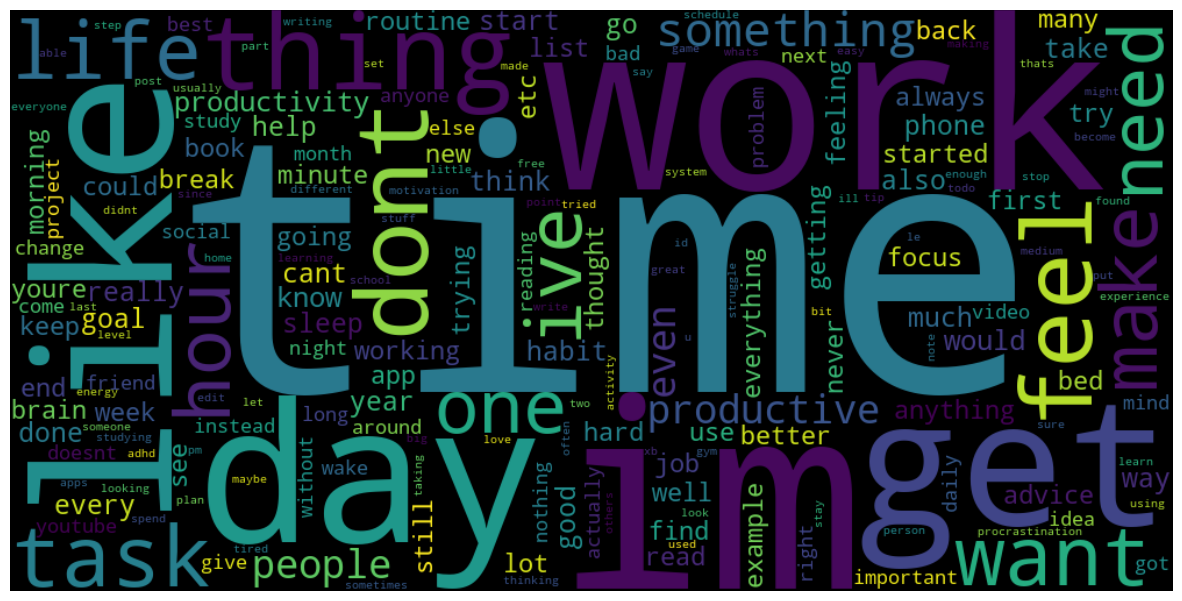

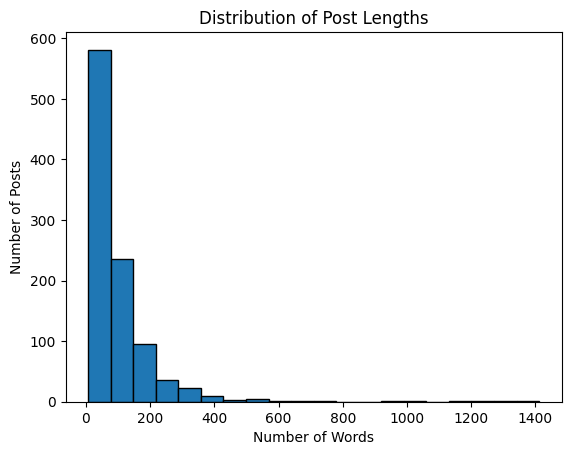

In [31]:
all_words = [word for token in df['tokens'] for word in token]
word_freq = Counter(all_words)
print(word_freq.most_common(10))  # Most common words

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_freq)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Histogram example: Displaying distribution of post lengths
post_lengths = df['tokens'].apply(len)
plt.hist(post_lengths, bins=20, edgecolor='black')
plt.title('Distribution of Post Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Number of Posts')
plt.show()

Removing high word count documents

In [32]:
df = df[post_lengths <= 400]

## Sentiment Analysis of Documents

In [33]:
sid = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    score = sid.polarity_scores(text)['compound']
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

df['vader_sentiment'] = df['cleaned_text'].apply(vader_sentiment)
df['vader_polarity'] = df['cleaned_text'].apply(lambda x: sid.polarity_scores(x)['compound'])

In [34]:
most_negative_texts = df.sort_values(by='vader_polarity', ascending=True).head(30)

sentiment_analysis_prompt = initial_prompt + "Theses are posts with high negative sentiment \n"
for index, row in most_negative_texts.iterrows():
    sentiment_analysis_prompt +=  row['cleaned_text'] + "\n"


In [35]:
print(sentiment_analysis_prompt)

I am looking for a list of specific problems that could be solved with a SaaS or technology solution, interpret these results from the productivity subreddit and give me a list of 10 solvable problems only present in the text. Theses are posts with high negative sentiment 
im so done with highschool i cant take this anymore xb  m th grade i do  subjects  ive been failing my exams not straight up fs but ive been doing badly ive been getting cs and ds sometimes nothing higher than c ive been having no motivation ive been lonely sad and just overall tired i feel like i have a bit of student burnout but honestly man im just so done with hs im in junior year and the teachers just dump and dump so much shit on us while putting the exams ontop of it no one is ready i heard someone or a group of people even went to the vice principal or supervisor to say they just arent ready for the exams on the days we dont have an exam were supposed to stay home but the teachers say we have to come into sch

### Summation of Problems

In [36]:
ask_chatgpt_result = ask_chatgpt(sentiment_analysis_prompt)
print(ask_chatgpt_result)

List of 10 solvable problems:

1. Lack of motivation and burnout in high school.
2. Procrastination and self-sabotage in job and career.
3. Fear of failure and self-sabotage in various areas of life.
4. Difficulty in managing time and staying organized.
5. Difficulty in starting tasks and poor task initiation.
6. Excessive smartphone use and internet addiction.
7. Lack of focus and difficulty in overcoming distractions.
8. Fatigue and lethargy, leading to low productivity.
9. Inability to overcome negative thought patterns and self-doubt.
10. Lack of accountability and difficulty in maintaining consistency.


## Latent Dirichlet Allocation (LDA) of All documents

In [44]:
# Topic Modeling using LDA
dictionary = corpora.Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(text) for text in df['tokens']]
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=5)
print(lda.print_topics())  # Display topics

[(0, '0.020*"time" + 0.016*"work" + 0.016*"im" + 0.010*"day" + 0.010*"get" + 0.007*"ive" + 0.007*"like" + 0.007*"hour" + 0.007*"dont" + 0.006*"need"'), (1, '0.014*"time" + 0.009*"like" + 0.009*"thing" + 0.009*"work" + 0.009*"im" + 0.008*"get" + 0.008*"productive" + 0.008*"feel" + 0.007*"dont" + 0.006*"life"'), (2, '0.012*"day" + 0.010*"time" + 0.010*"like" + 0.009*"thing" + 0.009*"work" + 0.008*"productive" + 0.007*"dont" + 0.007*"get" + 0.007*"one" + 0.007*"feel"'), (3, '0.014*"like" + 0.014*"im" + 0.014*"day" + 0.011*"get" + 0.009*"work" + 0.009*"feel" + 0.008*"thing" + 0.007*"ive" + 0.006*"life" + 0.006*"would"'), (4, '0.013*"im" + 0.011*"work" + 0.011*"time" + 0.009*"task" + 0.009*"like" + 0.009*"day" + 0.008*"thing" + 0.007*"want" + 0.007*"get" + 0.007*"dont"')]


In [45]:
# Get the topic distribution for each document
document_topics = [lda[doc] for doc in corpus]

# Get the dominant topic for each document
df['dominant_topic'] = [sorted(doc, key=lambda x: x[1], reverse=True)[0][0] for doc in document_topics]

# Get the strength (weight) of the dominant topic for each document
df['topic_strength'] = [sorted(doc, key=lambda x: x[1], reverse=True)[0][1] for doc in document_topics]

# Extract text of topics
topic_raw_data = list(lda.show_topics())
topics = [re.findall(r'"\w+"', topic_str) for _, topic_str in topic_raw_data]
# Removing quotation marks around words
cleaned_topics = [[word[1:-1] for word in topic] for topic in topics]

# 2. Sort & Review
num_docs_to_review = 2  # or however many you want to review for each topic

lda_prompt = initial_prompt + "Theses are topics and document examples from Latent Dirichlet Allocation:"
for topic_num in range(lda.num_topics):
    topic = topic_raw_data[topic_num]
    # print(f"Top documents for Topic {topic_num}: {topic}")
    lda_prompt += f"LDA Topic {topic_num}: {topic}"
    
    top_docs_for_topic = df[df['dominant_topic'] == topic_num].sort_values('topic_strength', ascending=False).head(num_docs_to_review)
    for index, row in top_docs_for_topic.iterrows():
        lda_prompt  += f"\n Document Example: {index}. '{row['text']}'" 
    
print(lda_prompt)

I am looking for a list of specific problems that could be solved with a SaaS or technology solution, interpret these results from the productivity subreddit and give me a list of 10 solvable problems only present in the text. Theses are topics and document examples from Latent Dirichlet Allocation:LDA Topic 0: (0, '0.020*"time" + 0.016*"work" + 0.016*"im" + 0.010*"day" + 0.010*"get" + 0.007*"ive" + 0.007*"like" + 0.007*"hour" + 0.007*"dont" + 0.006*"need"')
 Document Example: 307. 'I absolutely hate grouped projects 16M. 11th grade

Usually id just start my grouped projects early most of the time, but this time, I had so much work that I literally had 0 time to focus on it. I wanted to start, but I just couldnt because of my huge workload for other subjects. Im doing 8 subjects right now.

I was hoping at least 1 guy would type in the group, but no. No one said a thing. On the night before the presentation, I said in the group chat that we had to start this now, and if anyone can give

In [53]:
lda_ask_chatgpt_result = ask_chatgpt(lda_prompt)
print(lda_ask_chatgpt_result)

List of 10 solvable problems:

1. Lack of communication and collaboration in group projects, leading to one person having to do all the work.
2. Chronic lateness and poor time management.
3. Inefficiency and lack of productivity due to distractions and feeling overwhelmed by a long to-do list.
4. Disorganization and difficulty setting realistic goals and priorities.
5. Lack of focus and difficulty starting tasks due to fear or feeling unmotivated.
6. Feeling demoralized and unproductive due to a negative mindset and fear of making mistakes.
7. Feeling overwhelmed by the unknown steps and complexities of a task, leading to procrastination.
8. Difficulty breaking down large tasks into smaller, manageable steps.
9. Difficulty in starting and staying committed to a workout routine or other self-improvement activities.
10. Procrastination and emotional barriers to completing important tasks, leading to feelings of frustration and helplessness.


## Latent Dirichlet Allocation(LDA) of all negative douments

In [ ]:
df_negative = df[df["vader_sentiment"] == "negative"].copy(deep=True)

# Topic Modeling using LDA
dictionary = corpora.Dictionary(df_negative['tokens'])
corpus = [dictionary.doc2bow(text) for text in df_negative['tokens']]
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=5)


# Get the topic distribution for each document
document_topics = [lda[doc] for doc in corpus]

# Get the dominant topic for each document
df_negative['dominant_topic'] = [sorted(doc, key=lambda x: x[1], reverse=True)[0][0] for doc in document_topics]

# Get the strength (weight) of the dominant topic for each document
df_negative['topic_strength'] = [sorted(doc, key=lambda x: x[1], reverse=True)[0][1] for doc in document_topics]

# Extract text of topics
topic_raw_data = list(lda.show_topics())
topics = [re.findall(r'"\w+"', topic_str) for _, topic_str in topic_raw_data]
# Removing quotation marks around words
cleaned_topics = [[word[1:-1] for word in topic] for topic in topics]

# 2. Sort & Review
num_docs_to_review = 2  # or however many you want to review for each topic

negative_lda_prompt = initial_prompt + "Theses are topics and document examples from Latent Dirichlet Allocation:"
for topic_num in range(lda.num_topics):
    topic = topic_raw_data[topic_num]
    negative_lda_prompt += f"LDA Topic {topic_num}: {topic}"
    
    top_docs_for_topic = df_negative[df_negative['dominant_topic'] == topic_num].sort_values('topic_strength', ascending=False).head(num_docs_to_review)
    for index, row in top_docs_for_topic.iterrows():
        negative_lda_prompt  += f"\n Document Example: {index}. '{row['text']}'" 
    
# print(negative_lda_prompt)

In [51]:
negative_lda_ask_chatgpt_result = ask_chatgpt(lda_prompt)
print(negative_lda_ask_chatgpt_result)

List of 10 solvable problems:

1. Lack of communication and teamwork in group projects
2. Chronic lateness and time management issues
3. Inefficiency and lack of productivity in the morning
4. Poorly written and unhelpful self-help books
5. Lack of self-awareness and difficulty reflecting on actions and choices
6. Lack of motivation and feeling overwhelmed by tasks
7. Difficulty in focusing and starting tasks due to fear or perfectionism
8. Feeling demoralized and distracted by long to-do lists
9. Overwhelm and anxiety caused by unknown steps in tasks
10. Procrastination due to emotional reasons and fear of failure


In [54]:
# Define the number of topics you want
n_topics = 10

# Transform data using TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df['text'])

# Apply NMF
nmf = NMF(n_components=n_topics, init='nndsvd', solver='cd', beta_loss='frobenius', random_state=1, l1_ratio=.5).fit(tfidf)

# Print the topics discovered by NMF
feature_names = tfidf_vectorizer.get_feature_names_out()
top_10_per_topic_list = []
for topic_idx, topic in enumerate(nmf.components_):
    top_10_per_topic_list.append(" ".join([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]))
    
# First, transform your original matrix using the trained NMF model
W = nmf.transform(tfidf)

# Assign the topic with the highest coefficient as the dominant topic for each text
df['dominant_topic'] = W.argmax(axis=1)

# Now, extract and review texts for each topic
documents_per_topic = 5

nmf_prompt = initial_prompt + "Theses are topics and document examples from Non-negative Matrix Factorization \n"
for topic_num in range(nmf.n_components_):  # Loop through all topics
    nmf_prompt += f"Topic #{topic_num + 1} top words: {top_10_per_topic_list[topic_num]}\n"
    
    sample_texts_for_topic = df[df['dominant_topic'] == topic_num]['text'].sample(documents_per_topic)
    
    for idx, text in sample_texts_for_topic.items():
        nmf_prompt += text

/Users/matthewcarter/.local/share/virtualenvs/reddit-scraper-_tJTTXAU/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [55]:
print(nmf_prompt)

I am looking for a list of specific problems that could be solved with a SaaS or technology solution, interpret these results from the productivity subreddit and give me a list of 10 solvable problems only present in the text. Theses are topics and document examples from Non-negative Matrix Factorization 
Topic #1 top words: want things just don doing need know life ve think
More you seek the uncomfortable, the more comfortable you become This philosophy has helped me a lot in trying activities that I had no experience in but wanted to learn. 

I always wanted to learn martial arts but I had no experience of any form. An year ago when I started, I was probably the worst in the class. I applied the philosophy and just accepted that being uncomfortable and not good at something is just part of the process. I internalized that each day I perform badly is one day closer to when I am good. Few weeks ago I won silver in my first competition.

If any of you guys out there are trying something

In [56]:
nmf_ask_chatgpt_result = ask_chatgpt(nmf_prompt)
print(nmf_ask_chatgpt_result)

1. Disorganization and forgetfulness at work - SaaS or technology solution for organization and note-taking tools like Notion or Evernote.
2. Lack of motivation and doubting oneself - SaaS or technology solution for productivity and motivation tools like Todoist or other task management apps.
3. Procrastination and difficulty starting tasks - SaaS or technology solution for time management and task prioritization tools like time-blocking apps or Pomodoro timers.
4. Phone and social media addiction - SaaS or technology solution for digital detox and blocking apps for limiting social media usage.
5. Difficulty waking up and establishing a morning routine - SaaS or technology solution for alarm clocks or apps with features like sunrise alarm or sleep tracking.
6. Feeling overwhelmed and obsessed with productivity - SaaS or technology solution for task management apps or productivity tools like Skedpal or Trello.
7. Struggles with maintaining routines and staying focused - SaaS or technolo